In [1]:
# Imports required for this project
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

tf.random.set_seed(4)

2023-07-03 11:48:16.989645: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Creating the Pathlib PATH objects
train_path = Path("train")
validation_path = Path("test")
test_path = Path("val")

In [3]:
# Collecting all the Paths Inside "Normal" and "Pneumonia" folders of the above paths
train_image_paths = train_path.glob("*/*")
val_image_paths = validation_path.glob("*/*")

# Output is a Generator object
print(train_image_paths)

<generator object Path.glob at 0x7fd45bb960b0>


In [4]:
# Convert Generator Object to List of elements
train_image_paths = list(train_image_paths)
val_image_paths = list(val_image_paths)

# Now the outputs are "PosixPath" objects
print(train_image_paths[:3])

[PosixPath('train/PNEUMONIA/person63_bacteria_306.jpeg'), PosixPath('train/PNEUMONIA/person1438_bacteria_3721.jpeg'), PosixPath('train/PNEUMONIA/person755_bacteria_2659.jpeg')]


In [5]:
# Convert Posix paths to normal strings
train_image_paths = list(map(lambda x: str(x) , train_image_paths))
val_image_paths = list(map(lambda x: str(x) , val_image_paths))

print(train_image_paths[:3])

['train/PNEUMONIA/person63_bacteria_306.jpeg', 'train/PNEUMONIA/person1438_bacteria_3721.jpeg', 'train/PNEUMONIA/person755_bacteria_2659.jpeg']


In [6]:
# Collect Length for Training and Validation datasets
train_dataset_length = len(train_image_paths)
val_dataset_length = len(val_image_paths)

In [7]:
# Every Image has label in its path, so lets slice it
LABELS = {'NORMAL' : 0 , 'PNEUMONIA' : 1}
INV_LABELS = {0 : 'NORMAL' , 1 : 'PNEUMONIA'}

def get_label(path : str) -> int:
    return LABELS[path.split("/")[-2]]

train_labels = list(map(lambda x : get_label(x) , train_image_paths))
val_labels = list(map(lambda x : get_label(x) , val_image_paths))
                    
print(train_labels[:3])

[1, 1, 1]


In [8]:
# Function used to create a Tensorflow Data Object
def get_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)
    
    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)
    
    dataset = tf.data.Dataset.zip((image_dataset , label_dataset)).shuffle(1000)
    
    dataset = dataset.map(lambda image , label : load_and_transform(image , label , train))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    
    return dataset

In [9]:
# Now we have all training, validation image paths and their respective labels

BATCH_SIZE = 32

# Function used for transformation 
def load_and_transform(image , label , train = True):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [224 , 224] , method="nearest")
    if train:
        image = tf.image.random_flip_left_right(image)
    return image , label

In [10]:
# Creating Train Dataset object and Verifying it
%time train_dataset = get_dataset(train_image_paths , train_labels)

image , label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

CPU times: user 171 ms, sys: 30.3 ms, total: 201 ms
Wall time: 289 ms


2023-07-03 12:01:24.000443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5216]
	 [[{{node Placeholder/_0}}]]
2023-07-03 12:01:24.001508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int32 and shape [5216]
	 [[{{node Placeholder/_2}}]]


(32, 224, 224, 3)
(32,)


PNEUMONIA


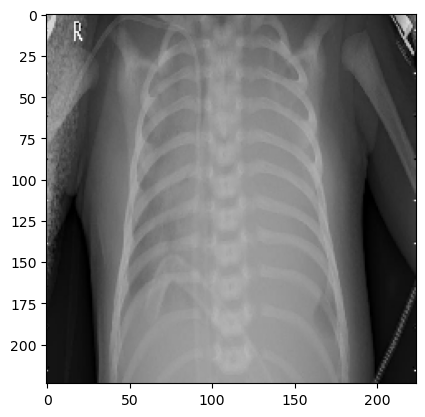

In [11]:
# View a sample Train Image
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224 , 224 , 3))

In [12]:
%time val_dataset = get_dataset(val_image_paths , val_labels , train = False)

image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 21 ms, sys: 2.21 ms, total: 23.2 ms
Wall time: 21.6 ms


2023-07-03 12:05:28.595811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int32 and shape [624]
	 [[{{node Placeholder/_2}}]]
2023-07-03 12:05:28.596240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [624]
	 [[{{node Placeholder/_0}}]]


(32, 224, 224, 3)
(32,)


In [14]:
# Building ResNet50 model
from tensorflow.keras.applications import ResNet50V2

backbone = ResNet50V2(
input_shape=(224, 224, 3),
include_top=False)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 23,521,409
Non-trainable params: 45,440
_________________________________________________________________


In [15]:
# Compiling your model by providing the Optimizer , Loss and Metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'binary_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [16]:
# Defining our callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5",verbose=1,
                                                save_best_only=True,save_weights_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)

In [18]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_length//BATCH_SIZE,
    epochs=8,
    callbacks=[checkpoint , early_stop],
    validation_data=val_dataset,
    validation_steps = val_dataset_length//BATCH_SIZE,
)

Epoch 1/8
163/163 [==============================] - ETA: 0s - loss: 0.1751 - accuracy: 0.9419 - precision: 0.9572 - recall: 0.9715
Epoch 1: val_loss improved from inf to 57.56381, saving model to best_weights.h5
163/163 [==============================] - 987s 6s/step - loss: 0.1751 - accuracy: 0.9419 - precision: 0.9572 - recall: 0.9715 - val_loss: 57.5638 - val_accuracy: 0.3651 - val_precision: 1.0000 - val_recall: 0.0026
Epoch 2/8
163/163 [==============================] - ETA: 0s - loss: 0.1294 - accuracy: 0.9542 - precision: 0.9673 - recall: 0.9711
Epoch 2: val_loss improved from 57.56381 to 1.36990, saving model to best_weights.h5
163/163 [==============================] - 1441s 9s/step - loss: 0.1294 - accuracy: 0.9542 - precision: 0.9673 - recall: 0.9711 - val_loss: 1.3699 - val_accuracy: 0.6875 - val_precision: 0.9409 - val_recall: 0.5176
Epoch 3/8
163/163 [==============================] - ETA: 0s - loss: 0.0967 - accuracy: 0.9645 - precision: 0.9758 - recall: 0.9770
Epoch 3:

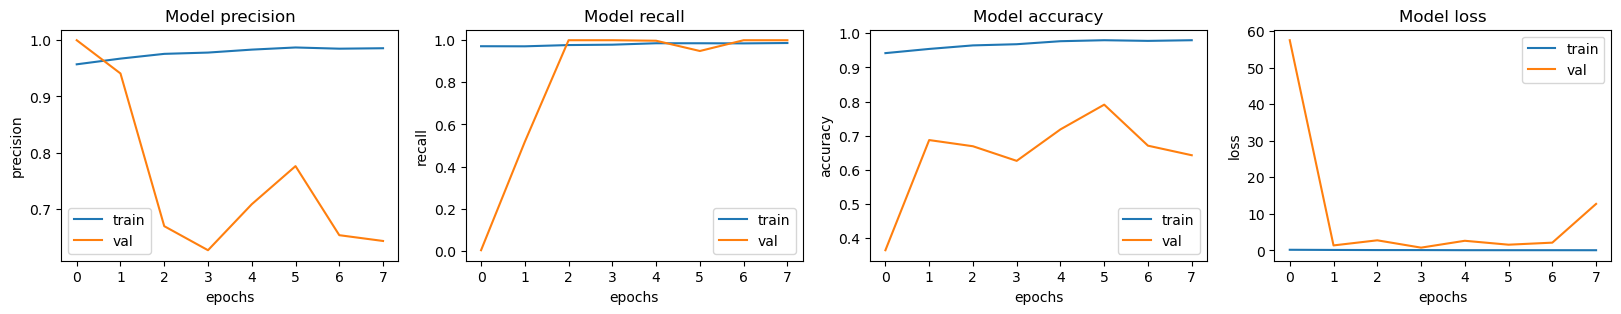

In [19]:
# Interpreting the Metrics
fig, ax = plt.subplots(1, 4, figsize=(20,3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [20]:
# Saving the best Model

# Load the best weights
model.load_weights("best_weights.h5")
# Save the whole model (weights + architecture)
model.save("model.h5")

In [21]:
# Loading the whole model
loaded_model = tf.keras.models.load_model("model.h5")

In [23]:
# Create a Dataset Object for 'Testing' Set just the way we did for Training and Validation
test_image_paths = list(test_path.glob("*/*"))
test_image_paths = list(map(lambda x : str(x) , test_image_paths))
test_labels = list(map(lambda x : get_label(x) , test_image_paths))

test_image_paths = tf.convert_to_tensor(test_image_paths)
test_labels = tf.convert_to_tensor(test_labels)

def decode_image(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image, [224 , 224] , method="nearest")
    return image , label

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((test_image_paths, test_labels))
    .map(decode_image)
    .batch(BATCH_SIZE)
)

In [24]:
# Verify Test Dataset Object
image , label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

(16, 224, 224, 3)
(16,)


2023-07-04 22:56:02.365661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [16]
	 [[{{node Placeholder/_1}}]]


PNEUMONIA


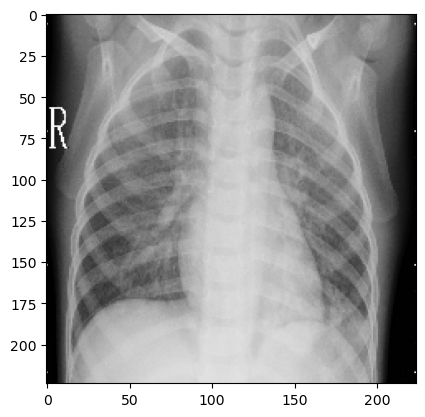

In [25]:
# View a sample validation image
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224 , 224 , 3))

In [26]:
# Evaluating the loaded model
loss, acc, prec, rec = loaded_model.evaluate(test_dataset)

print(" Testing Acc : " , acc)
print(" Testing Precision " , prec)
print(" Testing Recall " , rec)

1/1 [==============================] - 2s 2s/step - loss: 0.9785 - accuracy: 0.5000 - precision: 0.5000 - recall: 1.0000
 Testing Acc :  0.5
 Testing Precision  0.5
 Testing Recall  1.0
